In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# New section

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
import keras
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom
from stochastic.processes.continuous import FractionalBrownianMotion

%load_ext autoreload
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-05-06 13:40:58.285184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 13:40:58.800866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jwoo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-06 13:40:59.782610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 13:40:59.820236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 13:40:59.820298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
SHUFFLE = True
MAX_EPOCHS = 10000
BATCH_SIZE = 1024
PATIENCE = 100
N = 10
T = 200
L = None

NB_INPUT_FEATURES = 1
SEARCH_WIDTH = 2
WINDOW_WIDTHS = [36, 48, 60, 72, 84]
SHIFT_WIDTH = 30
JUMP_D = 15

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [4]:
def slice_data(signal_seq, jump_d=15):
    slice_d = []
    indice = []
    std_signal = np.std(signal_seq, axis=1).reshape(-1, 1)
    mean_signal = np.mean(signal_seq, axis=1).reshape(-1, 1)
    for i in range(SHIFT_WIDTH//2, signal_seq.shape[1] - SHIFT_WIDTH//2, jump_d):
        crop = signal_seq[:, i - SHIFT_WIDTH//2: i + SHIFT_WIDTH//2]
        crop = np.hstack((crop, mean_signal))
        crop = np.hstack((crop, std_signal))
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice)

In [5]:
def merge_close_points(changepoints, signals, seuil=5):
    seq_sums = []
    for i in range(len(signals)):
        tmp = []
        for j in range(len(signals[i])):
            if j < SEARCH_WIDTH:
                tmp.append(signals[i][j] * ((SEARCH_WIDTH * 2) + 1))
            elif j > len(signals[i]) - 1 - SEARCH_WIDTH:
                tmp.append(signals[i][j] * ((SEARCH_WIDTH * 2) + 1))
            else:
                tmp.append(np.sum(signals[i][j-SEARCH_WIDTH:j+SEARCH_WIDTH+1]))
        tmp = np.array(tmp)
        seq_sums.append(tmp)
    seq_sums = np.array(seq_sums)
    seq_sums = np.sum(seq_sums, axis=0)
    val_orders = np.argsort(seq_sums[changepoints])[::-1]
    
    filtered_cps = []
    all_cps_range = set()
    for cp in changepoints[val_orders]:
        regis_cp_range = np.arange(-seuil + cp, seuil + cp)
        if len(set(regis_cp_range) & all_cps_range) == 0:
            filtered_cps.append(cp)
            all_cps_range.update(regis_cp_range)
    filtered_cps = np.array(filtered_cps)
    return filtered_cps

In [6]:
def ana_cp_predict(x, y, win_widths, search_width, jump_d):
    signal_seq = make_signal(x, y, win_widths, search_width)
    predict_input, indice = slice_data(signal_seq, jump_d=jump_d)
    activ_nb_win = np.sum(np.array(win_widths) <= np.array([len(x)] * len(win_widths)))
    if activ_nb_win > 0:
        predict_input = np.array(predict_input).reshape(-1, activ_nb_win*2, SHIFT_WIDTH+2, 1)
        pred = classification_model.predict(predict_input, verbose=0).flatten()
        cps = indice[np.round(pred) >= 1]
        if len(cps) == 0:
            return []
        reg_inputs = []
        for cp in cps:
            reg_inputs.append(signal_seq[:, cp - (SHIFT_WIDTH//2): cp + (SHIFT_WIDTH//2)])
        reg_inputs = np.array(reg_inputs).reshape(-1, activ_nb_win*2, SHIFT_WIDTH, 1)
        reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
        cps = np.round(cps + reg_outputs).astype(int)
        cps = merge_close_points(cps, signal_seq)
        return cps
    else:
        return []

In [7]:
def alphas_2_cps(alpha_seq):
    cp_seq = []
    alpha = alpha_seq[0]
    for next_alpha in alpha_seq[1:]:
        if alpha != next_alpha:
            cp_seq.append(1)
        else:
            cp_seq.append(0)
        alpha = next_alpha
    cp_seq.append(0)
    return np.array(cp_seq)

In [8]:
def make_signal(x_pos, y_pos, win_widths, search_width, normalization=True):
    all_vals = []
    for win_width in win_widths:
        vals = []
        for checkpoint in range(int(win_width/2), len(x_pos) - int(win_width/2)):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 / win_width
            xs2 = xs2 / win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 / win_width 
            ys2 = ys2 / win_width

            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.concatenate((np.zeros(int(win_width/2)), vals))
        vals = np.concatenate((vals, np.zeros(int(win_width/2))))

        vals = np.array(vals)
        all_vals.append(vals)

    """
    avg_vals = []
    for i in range(len(all_vals)):
        tmp = []
        for j in range(len(all_vals[i])):
            if j < search_width:
                tmp.append(all_vals[i][j] * ((search_width * 2) + 1))
            elif j > len(all_vals[i]) - 1 - search_width:
                tmp.append(all_vals[i][j] * ((search_width * 2) + 1))
            else:
                tmp.append(np.sum(all_vals[i][j-search_width:j+search_width+1]))
        tmp = np.array(tmp)
        avg_vals.append(tmp)
    avg_vals = np.array(avg_vals)
    tmp = []
    for j in range(len(avg_vals[0])):
        tmp_sum = 0
        count = 0
        for i in range(len(avg_vals)):
            if avg_vals[i][j] != 0:
                tmp_sum += avg_vals[i][j]
                count += 1
        if count == 0:
            tmp.append(0)
        else:
            tmp.append(tmp_sum / count)
    avg_vals = np.array(tmp)
    all_vals.append(avg_vals)
    """
    
    all_vals = np.array(all_vals)
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return np.vstack((all_vals, normalized_vals))

In [9]:
def chop_with_shift(signal_seq, changepoints=None, count_0=None, count_1=None):
    chopped_signals = []
    chopped_labels = []
    reg_chopped_signals = []
    reg_chopped_labels = []
    pat=0
    
    std_signal = np.std(signal_seq, axis=1).reshape(-1, 1)
    mean_signal = np.mean(signal_seq, axis=1).reshape(-1, 1)

    if changepoints is not None:
        changepoints_reg = []
        for cp in changepoints:
            changepoints_reg.extend(range(cp - SHIFT_WIDTH//4, cp + SHIFT_WIDTH//4))
        changepoints_reg = set(changepoints_reg)
        if len(changepoints) != 0:
            for cp in changepoints:
                if cp >= (SHIFT_WIDTH//2) and cp < signal_seq.shape[1] - (SHIFT_WIDTH//2):
                    same_c = 0
                    tmp2 = np.hstack((signal_seq[:, cp - (SHIFT_WIDTH//2):cp + (SHIFT_WIDTH//2)], mean_signal))
                    tmp2 = np.hstack((tmp2, std_signal))
                    chopped_signals.append(tmp2)
                    chopped_labels.append(1)
                    count_1 += 1
                    while True:
                        pat += 1
                        random_selec = np.random.randint(0, T)
                        random_selec_reg = set(np.arange(random_selec - SHIFT_WIDTH//4, random_selec + SHIFT_WIDTH//4))
                        if len(changepoints_reg & random_selec_reg) == 0:
                            if random_selec >= (SHIFT_WIDTH//2) and random_selec < signal_seq.shape[1] - (SHIFT_WIDTH//2):
                                tmp1 = np.hstack((signal_seq[:, random_selec - (SHIFT_WIDTH//2):random_selec + (SHIFT_WIDTH//2)], mean_signal))
                                tmp1 = np.hstack((tmp1, std_signal))
                                chopped_signals.append(tmp1)
                                chopped_labels.append(0)

                                for relative_x in range(-SHIFT_WIDTH//2 + cp, SHIFT_WIDTH//2 + cp, 5):
                                    reg_signal_seq = signal_seq[:, relative_x - (SHIFT_WIDTH//2): relative_x + (SHIFT_WIDTH//2)]
                                    if reg_signal_seq.shape[1] == SHIFT_WIDTH:
                                        reg_chopped_signals.append(signal_seq[:, relative_x - (SHIFT_WIDTH//2): relative_x + (SHIFT_WIDTH//2)])
                                        reg_chopped_labels.append(cp - relative_x)
                                    
                            elif random_selec < (SHIFT_WIDTH//2):
                                tmp1 = np.hstack((signal_seq[:, random_selec:random_selec + SHIFT_WIDTH], mean_signal))
                                tmp1 = np.hstack((tmp1, std_signal))
                                chopped_signals.append(tmp1)
                                chopped_labels.append(0)

                                for relative_x in range(-SHIFT_WIDTH//2 + cp, SHIFT_WIDTH//2 + cp, 5):
                                    reg_signal_seq = signal_seq[:, relative_x - (SHIFT_WIDTH//2): relative_x + (SHIFT_WIDTH//2)]
                                    if reg_signal_seq.shape[1] == SHIFT_WIDTH:
                                        reg_chopped_signals.append(signal_seq[:, relative_x - (SHIFT_WIDTH//2): relative_x + (SHIFT_WIDTH//2)])
                                        reg_chopped_labels.append(cp - relative_x)
                                    
                            else:
                                tmp1 = np.hstack((signal_seq[:, random_selec - SHIFT_WIDTH:random_selec], mean_signal))
                                tmp1 = np.hstack((tmp1, std_signal))
                                chopped_signals.append(tmp1)
                                chopped_labels.append(0)

                                for relative_x in range(-SHIFT_WIDTH//2 + cp, SHIFT_WIDTH//2 + cp, 5):
                                    reg_signal_seq = signal_seq[:, relative_x - (SHIFT_WIDTH//2): relative_x + (SHIFT_WIDTH//2)]
                                    if reg_signal_seq.shape[1] == SHIFT_WIDTH:
                                        reg_chopped_signals.append(signal_seq[:, relative_x - (SHIFT_WIDTH//2): relative_x + (SHIFT_WIDTH//2)])
                                        reg_chopped_labels.append(cp - relative_x)
                                
                            count_0 += 1
                            same_c += 1
                            if same_c >= 3:
                                break
                        if pat >= 10:
                            break
        else:
            for _ in range(1):
                random_selec = np.random.randint(0, T)
                if random_selec >= (SHIFT_WIDTH//2) and random_selec < signal_seq.shape[1] - (SHIFT_WIDTH//2):
                    tmp1 = np.hstack((signal_seq[:, random_selec - (SHIFT_WIDTH//2):random_selec + (SHIFT_WIDTH//2)], mean_signal))
                    tmp1 = np.hstack((tmp1, std_signal))
                    chopped_signals.append(tmp1)
                    chopped_labels.append(0)
                elif random_selec < (SHIFT_WIDTH//2):
                    tmp1 = np.hstack((signal_seq[:, random_selec:random_selec + SHIFT_WIDTH], mean_signal))
                    tmp1 = np.hstack((tmp1, std_signal))
                    chopped_signals.append(tmp1)
                    chopped_labels.append(0)
                else:
                    tmp1 = np.hstack((signal_seq[:, random_selec - SHIFT_WIDTH:random_selec], mean_signal))
                    tmp1 = np.hstack((tmp1, std_signal))
                    chopped_signals.append(tmp1)
                    chopped_labels.append(0)
                count_0 += 1
        return np.array(chopped_signals), np.array(chopped_labels), count_0, count_1, np.array(reg_chopped_signals), np.array(reg_chopped_labels)
    else:
        for i in range(SHIFT_WIDTH//2, signal_seq.shape[1] - SHIFT_WIDTH//2, 15):
            crop = signal_seq[:, i - SHIFT_WIDTH//2: i + SHIFT_WIDTH//2]
            crop = np.hstack((crop, mean_signal))
            crop = np.hstack((crop, std_signal))
            chopped_signals.append(crop)
        return np.array(chopped_signals)

In [10]:
input_signals = []
input_labels = []
input_reg_signals = []
input_reg_labels = []

K_bound = [1e-12, 1000000.0]
alpha_bound = [0, 1.999]
alphas1 = [0.001, 0.6]
alphas2 = [1.4, 1.999]
count_0 = 0
count_1 = 0

for step in range(1500):
    if step % 10 == 0: print(step, count_0, count_1)
    alpha1 = np.random.uniform(alphas1[0], alphas1[1])
    alpha2 = np.random.uniform(alphas2[0], alphas2[1])
    single_alpha = np.random.choice([alpha1, alpha2])
    multi_trajs_model, multi_labels_model = models_phenom().multi_state(N=N,
                                                            L=L,
                                                            T=T,
                                                            alphas=[alpha1, alpha2],  # Fixed alpha for each state
                                                            Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[0.99, 0.01], [0.01, 0.99]]
                                                           )

    single_trajs_model, single_labels_model = models_phenom().multi_state(N=N,
                                                            L=L,
                                                            T=T,
                                                            alphas=[single_alpha, single_alpha],  # Fixed alpha for each state
                                                            Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[1.0, 0.0], [0.0, 1.0]]
                                                           )
    
    for i in range(N):
        multi_signal_seq = make_signal(multi_trajs_model[:, i, 0], multi_trajs_model[:, i, 1], WINDOW_WIDTHS, SEARCH_WIDTH)
        changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(multi_labels_model[:, i, :])
        chop_signal, chop_label, count_0, count_1, reg_signal, reg_label = chop_with_shift(multi_signal_seq, changepoints[:-1], count_0, count_1)        
        input_signals.extend(chop_signal)
        input_labels.extend(chop_label)
        input_reg_signals.extend(reg_signal)
        input_reg_labels.extend(reg_label)

        single_signal_seq = make_signal(single_trajs_model[:, i, 0], single_trajs_model[:, i, 1], WINDOW_WIDTHS, SEARCH_WIDTH)
        changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(single_labels_model[:, i, :])
        chop_signal, chop_label, count_0, count_1, _, _ = chop_with_shift(single_signal_seq, changepoints[:-1], count_0, count_1)        
        input_signals.extend(chop_signal)
        input_labels.extend(chop_label)

for i in range(500):
    single_trajs_model, single_labels_model = models_phenom().multi_state(N=2,
                                                            L=L,
                                                            T=T,
                                                            alphas=[1.0, 1.0],  # Fixed alpha for each state
                                                            Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[1.0, 0.0], [0.0, 1.0]]
                                                           )
    single_signal_seq = make_signal(single_trajs_model[:, 0, 0], single_trajs_model[:, 0, 1], WINDOW_WIDTHS, SEARCH_WIDTH)
    changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(single_labels_model[:, 0, :])
    chop_signal, chop_label, count_0, count_1, _, _ = chop_with_shift(single_signal_seq, changepoints[:-1], count_0, count_1)        
    input_signals.extend(chop_signal)
    input_labels.extend(chop_label)

input_signals = np.array(input_signals)
input_labels = np.array(input_labels)
input_reg_signals = np.array(input_reg_signals)
input_reg_labels = np.array(input_reg_labels)

0 0 0


KeyboardInterrupt: 

In [9]:
print(count_0, count_1)
total = count_0 + count_1
weight_for_0 = (1 / count_0) * (total / 2.0)
weight_for_1 = (1 / count_1) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(input_signals.shape, input_labels.shape)
print(input_reg_signals.shape, input_reg_labels.shape)
print(class_weight)

78854 25852
(104706, 10, 32) (104706,)
(351576, 10, 30) (351576,)
{0: 0.6639231998376747, 1: 2.025104440662231}


In [ ]:
shuffle_index1 = np.arange(input_signals.shape[0])
shuffle_index2 = np.arange(input_reg_signals.shape[0])
np.random.shuffle(shuffle_index1)
np.random.shuffle(shuffle_index2)
input_signals = input_signals.reshape(-1, 10, SHIFT_WIDTH+2)[shuffle_index1]
input_labels = input_labels.reshape(-1, 1)[shuffle_index1]
input_reg_signals = input_reg_signals.reshape(-1, 10, SHIFT_WIDTH)[shuffle_index2]
input_reg_labels = input_reg_labels.reshape(-1, 1)[shuffle_index2]

In [84]:
input_signals = input_signals.reshape(-1, 10, SHIFT_WIDTH+2, 1)
input_labels = input_labels.reshape(-1, 1)
input_reg_signals = input_reg_signals.reshape(-1, 10, SHIFT_WIDTH, 1)
input_reg_labels = input_reg_labels.reshape(-1, 1)
print(input_signals.shape, input_labels.shape)
print(input_reg_signals.shape, input_reg_labels.shape)

train_input = []
train_label = []
val_input = []
val_label = []
cur_count_0 = 0
cur_count_1 = 0
for i in range(len(input_labels)):
    if input_labels[i] == 0:
        cur_count_0 += 1
        if cur_count_0 < int(count_0 * 0.8):
            train_input.append(input_signals[i])
            train_label.append(input_labels[i])
        else:
            val_input.append(input_signals[i])
            val_label.append(input_labels[i])
    else:
        cur_count_1 += 1
        if cur_count_1 < int(count_1 * 0.8):
            train_input.append(input_signals[i])
            train_label.append(input_labels[i])
        else:
            val_input.append(input_signals[i])
            val_label.append(input_labels[i])
            
train_input = np.array(train_input)
train_label = np.array(train_label)
val_input = np.array(val_input)
val_label = np.array(val_label)

train_reg_input = input_reg_signals[:int(input_reg_signals.shape[0] * 0.8)]
val_reg_input = input_reg_signals[int(input_reg_signals.shape[0] * 0.8):]
train_reg_label = input_reg_labels[:int(input_reg_labels.shape[0] * 0.8)]
val_reg_label = input_reg_labels[int(input_reg_labels.shape[0] * 0.8):]
print(train_input.shape, train_label.shape, val_input.shape, val_label.shape)

(104706, 10, 32, 1) (104706, 1)
(351576, 10, 30, 1) (351576, 1)
(83762, 10, 32, 1) (83762, 1) (20944, 10, 32, 1) (20944, 1)


In [85]:
train_tf = tf.data.Dataset.from_tensor_slices((train_input, train_label)).batch(BATCH_SIZE)
val_tf = tf.data.Dataset.from_tensor_slices((val_input, val_label)).batch(BATCH_SIZE)
train_reg_tf = tf.data.Dataset.from_tensor_slices((train_reg_input, train_reg_label)).batch(BATCH_SIZE)
val_reg_tf = tf.data.Dataset.from_tensor_slices((train_reg_input, train_reg_label)).batch(BATCH_SIZE)
print(train_tf)
print(val_tf)
print(train_reg_tf)
print(val_reg_tf)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 10, 32, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 10, 32, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 10, 30, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 10, 30, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>


In [11]:
@tf.keras.utils.register_keras_serializable()
class Jaccard(tf.keras.Metric):
    def __init__(self, name='JSC', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_tp'
        )
        self.false_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fp'
        )
        self.false_negatives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fn'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(tf.math.round(y_pred), "bool")

        tp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        tp_values = tf.keras.ops.cast(tp_values, self.dtype)
        
        fp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        fp_values = tf.keras.ops.cast(fp_values, self.dtype)
        
        fn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        fn_values = tf.keras.ops.cast(fn_values, self.dtype)
        
        tn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        tn_values = tf.keras.ops.cast(tn_values, self.dtype)

        self.true_positives.assign(self.true_positives + tf.keras.ops.sum(tp_values))
        self.false_positives.assign(self.false_positives + tf.keras.ops.sum(fp_values))
        self.false_negatives.assign(self.false_negatives + tf.keras.ops.sum(fn_values))

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + self.false_negatives)

In [80]:
%%time

%autoreload 2
from Models import Anomalous_detection, Anomalous_regression

classification_model = Anomalous_detection()
classification_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3/2),
                             metrics=[tf.keras.metrics.BinaryAccuracy(name='Acc'),
                                      Jaccard(name='JSC', dtype=None)]
                            ) 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                 )
    
history = classification_model.fit(x=train_tf,
                                   validation_data=val_tf,
                                   epochs=MAX_EPOCHS,
                                   shuffle=True,
                                   callbacks=[early_stopping],
                                   class_weight=class_weight,
                                   verbose=2
                                  )
classification_model.save('classification_model.keras')

Epoch 1/10000
82/82 - 10s - 125ms/step - Acc: 0.6798 - JSC: 0.3663 - loss: 0.5620 - val_Acc: 0.7992 - val_JSC: 0.4754 - val_loss: 0.4569
Epoch 2/10000
82/82 - 7s - 87ms/step - Acc: 0.8183 - JSC: 0.5042 - loss: 0.4517 - val_Acc: 0.8405 - val_JSC: 0.5309 - val_loss: 0.3981
Epoch 3/10000
82/82 - 7s - 88ms/step - Acc: 0.8318 - JSC: 0.5294 - loss: 0.4205 - val_Acc: 0.8474 - val_JSC: 0.5424 - val_loss: 0.3697
Epoch 4/10000
82/82 - 7s - 90ms/step - Acc: 0.8309 - JSC: 0.5330 - loss: 0.4063 - val_Acc: 0.8448 - val_JSC: 0.5425 - val_loss: 0.3649
Epoch 5/10000
82/82 - 7s - 88ms/step - Acc: 0.8312 - JSC: 0.5349 - loss: 0.3993 - val_Acc: 0.8484 - val_JSC: 0.5496 - val_loss: 0.3573
Epoch 6/10000
82/82 - 7s - 91ms/step - Acc: 0.8351 - JSC: 0.5411 - loss: 0.3947 - val_Acc: 0.8525 - val_JSC: 0.5551 - val_loss: 0.3523
Epoch 7/10000
82/82 - 7s - 91ms/step - Acc: 0.8381 - JSC: 0.5451 - loss: 0.3913 - val_Acc: 0.8553 - val_JSC: 0.5595 - val_loss: 0.3491
Epoch 8/10000
82/82 - 7s - 89ms/step - Acc: 0.8412 - 

In [88]:
regression_model = Anomalous_regression()
regression_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                             metrics=[tf.keras.metrics.MeanAbsoluteError(
                                 name='mean_absolute_error', dtype=None)]
                        ) 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                 )
    
history = regression_model.fit(x=train_reg_tf,
                                   validation_data=val_reg_tf,
                                   epochs=MAX_EPOCHS,
                                   shuffle=True,
                                   callbacks=[early_stopping],
                                   verbose=2
                                  )
regression_model.save('regression_model.keras')

Epoch 1/10000
275/275 - 7s - 26ms/step - loss: 40.8529 - mean_absolute_error: 4.9515 - val_loss: 37.8962 - val_mean_absolute_error: 4.6403
Epoch 2/10000
275/275 - 4s - 16ms/step - loss: 37.2878 - mean_absolute_error: 4.6108 - val_loss: 36.5554 - val_mean_absolute_error: 4.4926
Epoch 3/10000
275/275 - 4s - 16ms/step - loss: 36.3989 - mean_absolute_error: 4.5283 - val_loss: 36.5054 - val_mean_absolute_error: 4.4922
Epoch 4/10000
275/275 - 4s - 16ms/step - loss: 35.8452 - mean_absolute_error: 4.4795 - val_loss: 36.2834 - val_mean_absolute_error: 4.4499
Epoch 5/10000
275/275 - 4s - 16ms/step - loss: 35.5164 - mean_absolute_error: 4.4533 - val_loss: 36.0882 - val_mean_absolute_error: 4.4425
Epoch 6/10000
275/275 - 4s - 16ms/step - loss: 35.2200 - mean_absolute_error: 4.4304 - val_loss: 35.3997 - val_mean_absolute_error: 4.4254
Epoch 7/10000
275/275 - 4s - 16ms/step - loss: 35.0113 - mean_absolute_error: 4.4110 - val_loss: 35.1286 - val_mean_absolute_error: 4.3811
Epoch 8/10000
275/275 - 4s 

[187 200]


TypeError: '>' not supported between instances of 'float' and 'NoneType'

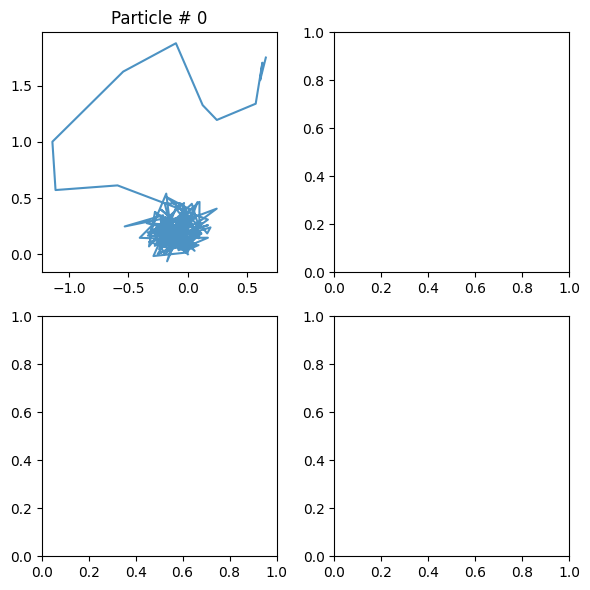

In [38]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.1, 1.5],
                                                        Ds=[[0.01, 0.0], [0.1, 0.0]],
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )
signal_seq = make_signal(trajs_model[:, 0, 0], trajs_model[:, 0, 1], WINDOW_WIDTHS, SEARCH_WIDTH)
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
print(changepoints)
plot_trajs(trajs_model[:, 0:2, :], L, 1, num_to_plot =2)

Model: "anomalous_detection_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm1d_6 (ConvLSTM1D)      │ ?                      │         8,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,845 (296.27 KB)

 Trainable params: 25,281 (98.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,564 (197.52 KB)

Model: "anomalous_regression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm1d_7 (ConvLSTM1D)      │ ?                      │         8,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │           481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,173 (106.15 KB)

 Trainable params: 9,057 (35.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,116 (70.77 KB)

(12, 10, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
TP cps: [187]
cps_before_reg: [ 90 180]
cps_after_reg: [181  91]


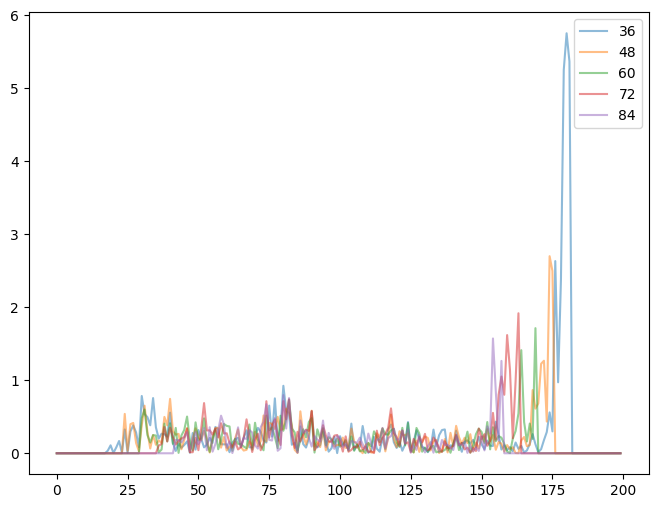

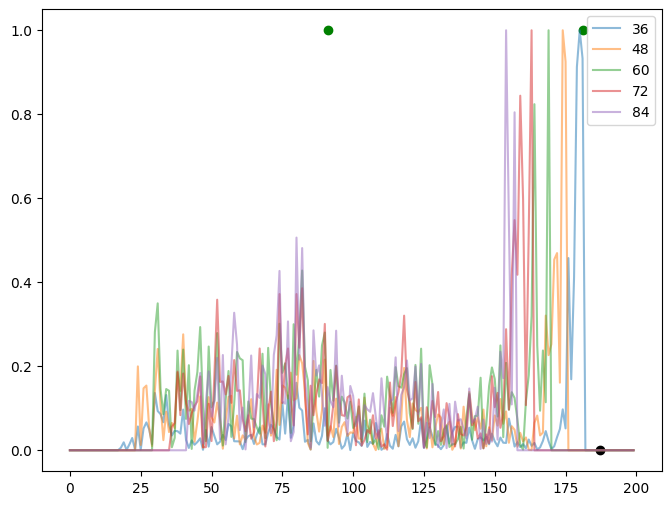

In [42]:
classification_model = tf.keras.models.load_model('classification_model_0.keras')
classification_model.summary()
regression_model = tf.keras.models.load_model('regression_model_0.keras')
regression_model.summary()

predict_input = chop_with_shift(signal_seq)
print(predict_input.shape)
predict_input = np.array(predict_input).reshape(-1, 10, SHIFT_WIDTH+2, 1)
pred = classification_model.predict(predict_input).flatten()

plt.figure()
for i in range(0, signal_seq.shape[0]//2):
    plt.plot(np.arange(T), signal_seq[i], alpha=0.5, label=f'{WINDOW_WIDTHS[i]}')
plt.legend()
#plt.ylim([0, 10])

plt.figure()
for i in range(0, signal_seq.shape[0]//2):
    plt.plot(np.arange(T), signal_seq[i + 5], alpha=0.5, label=f'{WINDOW_WIDTHS[i]}')
#plt.scatter(np.arange(SHIFT_WIDTH//2, signal_seq.shape[1] - SHIFT_WIDTH//2, 15), np.round(pred), c='red')
plt.scatter(changepoints[:-1], np.zeros(len(changepoints[:-1])), c='black')
plt.legend()
#plt.ylim([0, 10])


pred_args = np.arange(SHIFT_WIDTH//2, signal_seq.shape[1] - SHIFT_WIDTH//2, 15)[(np.round(pred) >= 1)]
reg_inputs = []
for pred_arg in pred_args:
    reg_inputs.append(signal_seq[:, pred_arg - (SHIFT_WIDTH//2): pred_arg + (SHIFT_WIDTH//2)])
reg_inputs = np.array(reg_inputs).reshape(-1, 10, SHIFT_WIDTH, 1)
reg_outputs = regression_model.predict(reg_inputs).flatten()



cps = ana_cp_predict(trajs_model[:, 0, 0], trajs_model[:, 0, 1], WINDOW_WIDTHS, SEARCH_WIDTH, JUMP_D)
plt.scatter(cps, np.array([1] * len(cps)), c='green')

print(f'TP cps: {changepoints[:-1]}')
print(f'cps_before_reg: {pred_args}')
print(f'cps_after_reg: {cps}')

0.04782685344485201 0.026529048455832198
0.09331995364121382 0.1283292820308269 0.14201949340272357 0.1064819259041734
0.050716741700803106 0.0020611926582831505
0.08864946044927534 0.12602855115379968 0.13156670998415307 0.105702525884788
-0.06815660787318 0.0733288675604387
0.08283817464787507 0.1377083310050979 0.12172533581581894 0.10412356569782898


-0.09365264672937959 0.06807242794934977
0.08468221371341897 0.13356065543009493 0.11707584572578171 0.11038666615653532
-0.09517722312190287 -0.053879125960101824
0.08601403221291797 0.13158975725216784 0.11152732991252928 0.10762987848562715
[0.13637625417262927, 0.0933911847378965, 0.010051756632926753, 0.04278990084440276, 0.23629346619540653]
0.5189025625832617


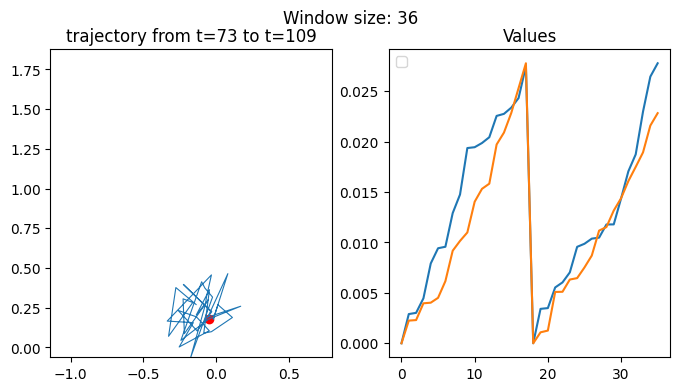

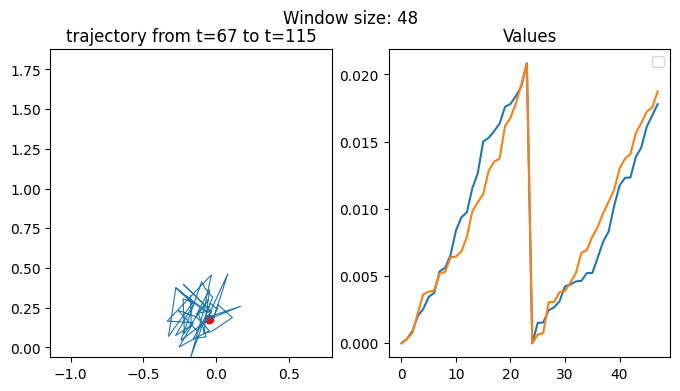

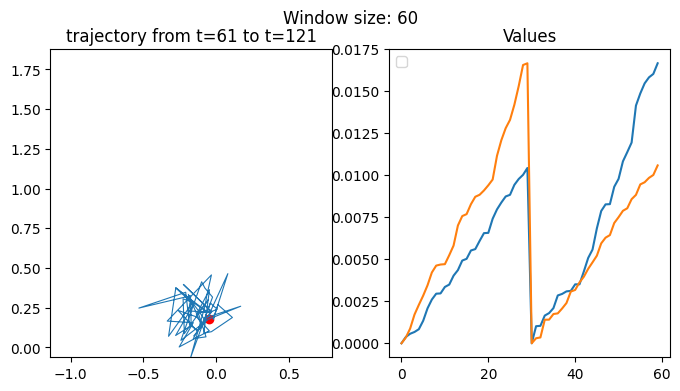

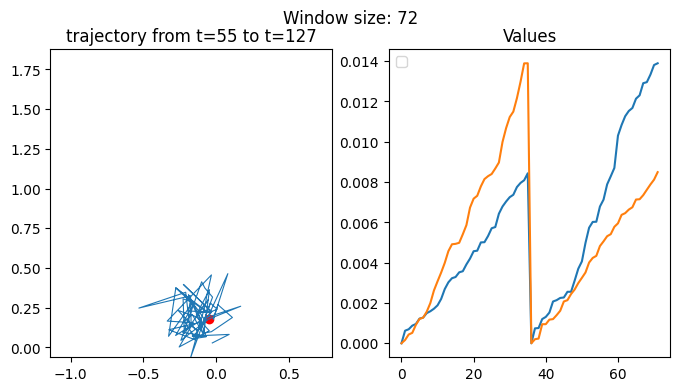

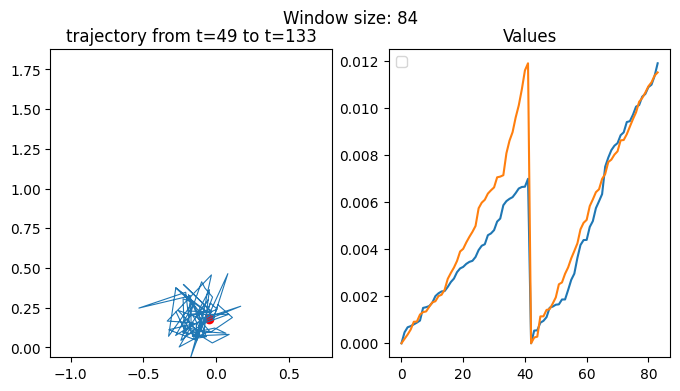

In [41]:
checkpoint = 91
val = []
for WINDOW_WIDTH in WINDOW_WIDTHS:
    if checkpoint - int(WINDOW_WIDTH/2) >= 0 and checkpoint + int(WINDOW_WIDTH/2) <= len(trajs_model[:, 0, 0]):
        xs = trajs_model[:, 0, 0][checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]
        ys = trajs_model[:, 0, 1][checkpoint - int(WINDOW_WIDTH/2) : checkpoint + int(WINDOW_WIDTH/2)]

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        plt.suptitle(f"Window size: {WINDOW_WIDTH}")
        ax1.plot(xs, ys, linewidth=0.8)
        ax1.scatter(xs[int(WINDOW_WIDTH/2)], ys[int(WINDOW_WIDTH/2)], c='red')

        ax1.set_xlim([np.min(trajs_model[:, 0, 0]),
              np.min(trajs_model[:, 0, 0]) + max(np.max(trajs_model[:, 0, 0]) - np.min(trajs_model[:, 0, 0]), 
                np.max(trajs_model[:, 0, 1]) - np.min(trajs_model[:, 0, 1]))])
        ax1.set_ylim([np.min(trajs_model[:, 0, 1]),
                  np.min(trajs_model[:, 0, 1]) + max(np.max(trajs_model[:, 0, 0]) - np.min(trajs_model[:, 0, 0]), 
                    np.max(trajs_model[:, 0, 1]) - np.min(trajs_model[:, 0, 1]))])


        #xs = xs / (np.std(xs))
        #xs = np.cumsum((uncumulate(xs)))
        #ys = ys / (np.std(ys))
        #ys = np.cumsum((uncumulate(ys)))
        #xs = uncumulate(xs)
        #ys = uncumulate(ys)

        xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
        xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])
        #xs1 = abs(xs1)
        #xs2 = abs(xs2)

        ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
        ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

        std_xs1 = np.std(xs1)
        std_xs2 = np.std(xs2)
        std_ys1 = np.std(ys1)
        std_ys2 = np.std(ys2)

        surface_xs1 = abs(np.sum(xs1)) / WINDOW_WIDTH
        surface_xs2 = abs(np.sum(xs2)) / WINDOW_WIDTH
        surface_ys1 = abs(np.sum(ys1)) / WINDOW_WIDTH
        surface_ys2 = abs(np.sum(ys2)) / WINDOW_WIDTH


        xs1 = np.cumsum(abs(xs1)) #* surface_xs1
        xs2 = np.cumsum(abs(xs2)) #* surface_xs2
        ys1 = np.cumsum(abs(ys1)) #* surface_ys1
        ys2 = np.cumsum(abs(ys2)) #* surface_ys2


        xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
        xs1 = xs1 / xs_max_val
        xs2 = xs2 / xs_max_val
        xs1 = xs1 / WINDOW_WIDTH
        xs2 = xs2 / WINDOW_WIDTH

        ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
        ys1 = ys1 / ys_max_val
        ys2 = ys2 / ys_max_val
        ys1 = ys1 / WINDOW_WIDTH 
        ys2 = ys2 / WINDOW_WIDTH


        """
        xs1 = uncumulate(xs1)
        xs2 = uncumulate(xs2)
        ys1 = uncumulate(ys1)
        ys2 = uncumulate(ys2)

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        vals.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)
        """

        #vals.append(((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2))
        #vals.append(np.sum((xs1 - ys1)**2 + (xs2 - ys2)**2))
        #val.append(np.sum((xs1 - xs2)**2 + (ys1 - ys2)**2))
        #val.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1])))
        #val.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)))
        #val.append(abs((surface_xs1 - surface_xs2) + (surface_ys1 - surface_ys2)))
        #val.append(abs((xs1[-1]- xs2[-1]) + (ys1[-1] - ys2[-1])))
        print(np.sum(xs1 - xs2), np.sum(ys1 - ys2))
        print(std_xs1, std_xs2, std_ys1, std_ys2)
        #val.append(abs(np.sum(xs1 - xs2)*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #               + np.sum(ys1 - ys2)*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2))))
        #val.append(abs((np.sum(xs1 - xs2))*(max(std_xs1, std_xs2) - min(std_xs1, std_xs2)) 
        #               + (np.sum(ys1 - ys2))*(max(std_ys1, std_ys2) - min(std_ys1, std_ys2))))
        val.append(abs(np.sum(xs1 - xs2) + np.sum(ys1 - ys2)) 
                   * abs((max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                         * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2))))

        #print((np.sum(xs1 - xs2))**2 + (np.sum(ys1 - ys2))**2)
        #val.append((abs(np.sum(xs1)) - abs(np.sum(xs2)))**2 + (abs(np.sum(ys1)) - abs(np.sum(ys2)))**2)

        #xs1 = xs1 / np.std(xs1)
        #xs2 = xs2 / np.std(xs2)
        #ys1 = ys1 / np.std(ys1)
        #ys2 = ys2 / np.std(ys2)

        #xs1 = np.cumsum(xs1)
        #xs2 = np.cumsum(xs2)
        #ys1 = np.cumsum(ys1)
        #ys2 = np.cumsum(ys2)
        #ys1 = abs(ys1)
        #ys2 = abs(ys2)

        """
        xs1 = xs1 / np.sum(xs1)
        xs2 = xs2 / np.sum(xs2)
        ys1 = ys1 / np.sum(ys1)
        ys2 = ys2 / np.sum(ys2)
        """
        """
        if np.sum(xs1) > np.sum(xs2):
            x_gap = abs(xs1 - xs2)
        else:
            x_gap = abs(xs2 - xs1)

        if np.sum(ys1) > np.sum(ys2):
            y_gap = abs(ys1 - ys2)
        else:
            y_gap = abs(ys2 - ys1)

        print(np.sum((x_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2
                     + (y_gap - np.arange(WINDOW_WIDTH/2)**2/np.max(np.arange(WINDOW_WIDTH/2)**2))**2))
        """
        
        my_xs = np.concatenate((xs1, xs2))
        my_ys = np.concatenate((ys1, ys2))

        #plt.title(f'WINDOW SIZE: {WINDOW_WIDTH}')
        ax2.plot(np.arange(WINDOW_WIDTH), my_xs)
        ax2.plot(np.arange(WINDOW_WIDTH), my_ys)
        ax1.set_title(f'trajectory from t={checkpoint - WINDOW_WIDTH//2} to t={checkpoint + WINDOW_WIDTH//2}')
        ax2.set_title(f'Values')
        plt.legend()
        plt.savefig(f'./{WINDOW_WIDTH}.png')
print(val)
print(np.sum(val))